In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
% matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import norm_spa_vecs, numpy_bytes_to_str

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [29]:
with h5py.File("../data/meg_ia_full_shuffled.h5py", "r") as fi:
    print(list(fi.keys()))
    inp = np.array(fi['input'])
    accum = list(np.array(fi['clean_accum']))
    #output = np.array(fi['output'])
    
    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    D = fi['vocab_vectors'].attrs['dimensions']
    
    #accum = np.array(fi['accum'])
    clean = np.array(fi['clean'])
    clean_accum = np.array(fi['clean_accum'])
    #de_out = np.array(fi['de_out'])

    dt = fi['t_range'].attrs['dt']
    t_range = np.arange(fi['t_range'][0], fi['t_range'][1], dt)
    t_pause = fi['t_range'].attrs['t_pause']
    t_present = fi['t_range'].attrs['t_present']

['clean', 'clean_accum', 'correct', 'fan1', 'fan2', 'foil1', 'foil2', 'input', 't_range', 'vocab_strings', 'vocab_vectors']


In [30]:
t_each = t_pause + t_present

td_each = int(t_each/dt)
td_pause = int(t_pause/dt)
td_present = int(t_present/dt)

In [31]:
vocab = spa.Vocabulary(D)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

In [54]:
fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

all_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs
pair_vecs = np.array(fan1_pair_vecs + fan2_pair_vecs)
n_fans = len(fan1) + len(fan2)

In [33]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt  - dt))

wins = (fan1_win, fan2_win, foil1_win, foil2_win)

In [70]:
with h5py.File("../data/learn_comb.h5py", "r") as fi:
    c_err = np.array(fi['err'])
    c_out = np.array(fi['clean_out'])
    c_decs = np.array(fi['dec'])

In [71]:
with h5py.File("../data/learn_dot.h5py", "r") as fi:
    d_err = np.array(fi['err'])
    d_out = np.array(fi['clean_out'])
    d_decs = np.array(fi['dec'])

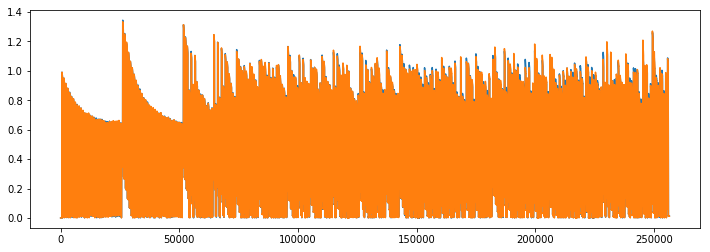

In [72]:
plt.figure(figsize=(12, 4))
plt.plot(np.abs(c_err))
plt.plot(np.abs(d_err))

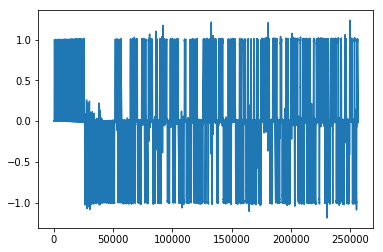

In [63]:
plt.plot(d_out)

In [64]:
c_decs[-1].shape

(1, 1000)

In [65]:
t_first_pass = int((len(all_vecs)*(t_present+t_pause) + t_pause)/dt)
test_input = inp[:t_first_pass]
test_accum = accum[:t_first_pass]

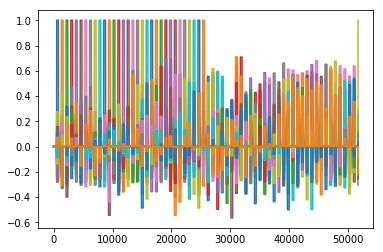

In [66]:
plt.plot(spa.similarity(test_input, fan1_pair_vecs+fan2_pair_vecs));

In [68]:
with nengo.Network(seed=8) as model:
    in_nd = nengo.Node(lambda t: inp[int(t/dt)])
    accum_out = nengo.Node(lambda t: accum[int(t/dt)])
    output = nengo.Node(size_in=1)

    cmp = nengo.Ensemble(1000, 2*D)

    nengo.Connection(accum_out, cmp[:n_fans], synapse=None)
    nengo.Connection(in_nd, cmp[n_fans:], synapse=None)
    nengo.Connection(cmp.neurons, output, transform=c_decs[-1])

    p_clean_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:36.                                                 


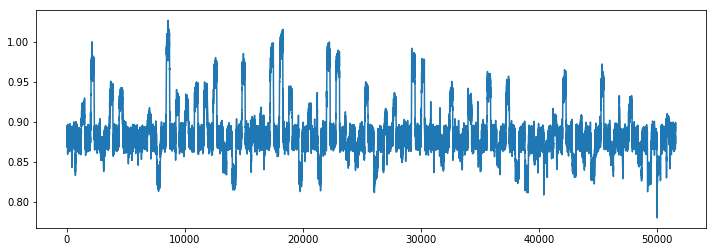

In [69]:
plt.figure(figsize=(12, 4))
plt.plot(sim.data[p_clean_out][100:])

In [55]:
with nengo.Network(seed=8) as model:
    in_nd = nengo.Node(lambda t: inp[int(t/dt)])
    accum_out = nengo.Node(lambda t: accum[int(t/dt)])
    output = nengo.Node(size_in=1)

    cmp = nengo.Ensemble(1000, 2*D)

    nengo.Connection(accum_out, cmp[D:],
                     transform=pair_vecs.T, synapse=None)
    nengo.Connection(in_nd, cmp[:D], synapse=None)
    nengo.Connection(cmp.neurons, output, transform=d_decs[-1])

    p_clean_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:56.                                                 


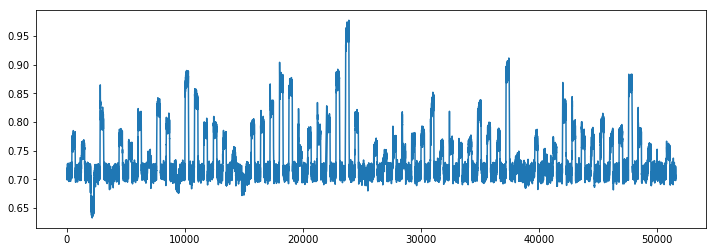

In [59]:
plt.figure(figsize=(12, 4))
plt.plot(sim.data[p_clean_out][100:])